# Supervised Learning Project | Vehicle Silhouettes

## 1 - Project Objective

**Prospect Auto**, a chain of car repair shops, has requested the development of a supervised learning model that can automatically classify vehicles into three categories using geometric features extracted from their silhouettes: `bus`, `van`, and `car`.

The purpose of this project is to determine whether silhouette-based features are sufficient to reliably distinguish between these vehicle types. To achieve this, the project will:

- Conduct an Exploratory Data Analysis (EDA) to understand the dataset both visually and numerically.
- Prepare the data for modeling and split it into training and test sets.
- Train and evaluate supervised classification models to address the classification problem.
- Assess model performance using standard classification metrics.
- Provide a conclusion on the model’s effectiveness and its potential suitability for Prospect Auto’s needs.

## 2 -  Data Import & Initial Inspection

### 2.1 - Import Libraries

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler

# Train/test split
from sklearn.model_selection import train_test_split

# Classification model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Model evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

### 2.2 - Load Dataset

In [4]:
# Read vehicle dataset as pandas DataFrame (assumes notebook started from the notebooks/ folder)
df = pd.read_csv('../data/vehicle-silhouettes.csv')

### 2.3 - Inspect Dataset

In [5]:
# Inspect shape of the vehicle dataset
df_rows_nr = df.shape[0]
df_cols_nr = df.shape[1]
print(f"Dataset Shape\nRows: {df_rows_nr}\nColumns: {df_cols_nr}")

Dataset Shape
Rows: 846
Columns: 19


In [6]:
# Review basic information about vehicle dataset
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyration.1  84

In [7]:
# Preview vehicle dataset
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


## 3 - Exploratory Data Analysis

### 3.1 - Data Cleaning

**Standardize Categorical Features**

To ensure consistency and avoid issues with hidden formatting, I first clean the `class` column by trimming any leading or trailing whitespace and converting all values to lowercase. This standardization prevents duplicate categories that differ only by spacing or capitalization. Once cleaned, I convert the column from  _object_  to  _category_  to reflect its categorical nature and improve efficiency.

In [8]:
# Clean up the target column to ensure consistency
df['class'] = df['class'].str.strip()
df['class'] = df['class'].str.lower()

# Convert class from object to category to improve efficiency
df['class'] = df['class'].astype('category')

The `class` column is the target variable and the only categorical feature in the dataset. I confirm that it only contains three unique values: `car`, `bus`, and `van`.

In [9]:
# Confirm unique values in target variable and distribution
df['class'].value_counts()

class
car    429
bus    218
van    199
Name: count, dtype: int64

**Remove Duplicate Rows**

In [10]:
# Check for duplicate rows
nr_duplicate_rows = df.duplicated().sum()

print(f"Number of duplicate rows: {nr_duplicate_rows}")

Number of duplicate rows: 0


No duplicate rows were found, so the dataset is already unique and no further action is required.

**Handle Missing Values**

In [11]:
# Check for missing values
print(df.isnull().sum())

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64


In [12]:
# Subset of columns with missing values
cols_with_na = df.columns[df.isna().any()].tolist()

# See how many rows are missing values in a combination of these columns
df[cols_with_na].isnull().sum(axis=1).value_counts()

0    813
1     26
2      6
3      1
Name: count, dtype: int64

The dataset contains 846 rows and 19 columns. A total of 33 rows (approximately 3.9%) include at least one missing value, while the remaining 813 rows are complete. Given the small proportion of missing data, it is reasonable to consider dropping these rows rather than applying imputation strategies.

Before making this decision, however, it is important to examine the distribution of missing values across the target classes to ensure that no class is disproportionately affected.

In [13]:
# Subset rows with at least one missing value
missing_rows = df[df[cols_with_na].isnull().any(axis=1)]

# Compare class distribution in missing vs full dataset
print("Overall class distribution:")
print(df['class'].value_counts(normalize=True))

print("\nClass distribution among rows with missing values:")
print(missing_rows['class'].value_counts(normalize=True))

Overall class distribution:
class
car    0.507092
bus    0.257683
van    0.235225
Name: proportion, dtype: float64

Class distribution among rows with missing values:
class
car    0.484848
bus    0.393939
van    0.121212
Name: proportion, dtype: float64


When comparing class distributions, we observe that rows with missing values are somewhat overrepresented in the `bus` class and underrepresented in the `van` class. However, as the total number of affected rows is very small (33 out of 846), the impact on class balance after removal is negligible. Dropping these rows simplifies preprocessing and ensures that all subsequent analyses are performed on complete cases without introducing bias from imputation.

In [14]:
# Drop rows with missing values in place
df.dropna(inplace=True)

# Calculate number of rows dropped
rows_dropped = df_rows_nr - df.shape[0]
print(f"Number of rows dropped: {rows_dropped}")

# Confirm new shape
print(f"\nDataset Shape after Rows Dropped\nRows: {df.shape[0]}\nColumns: {df.shape[1]}")

# Recheck class distribution after dropping
print("\nClass distribution after dropping missing rows:")
print(df['class'].value_counts(normalize=True))

# Confirm no missing values remain
print("\nRemaining missing values per column:")
print(df.isnull().sum())

Number of rows dropped: 33

Dataset Shape after Rows Dropped
Rows: 813
Columns: 19

Class distribution after dropping missing rows:
class
car    0.507995
bus    0.252153
van    0.239852
Name: proportion, dtype: float64

Remaining missing values per column:
compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64


After dropping the 33 incomplete rows, the dataset now contains 813 complete cases. The class distribution remained nearly identical to the original, confirming that the removal had only a negligible effect on balance. A final check verified that no missing values remain in any column, ensuring the dataset is clean and ready for exploratory data analysis.

**Exporting the Clean Dataset**

After completing the data cleaning process, the final preprocessed dataset is exported to a CSV file, preserving all applied transformations in a reusable format. This ensures the cleaned data can be reloaded directly for the follow‑up unsupervised learning project without repeating the entire cleaning workflow.

In [15]:
# Export cleaned vehicle dataset to .csv to reuse (save in repo data folder)
df.to_csv("../data/vehicle-silhouettes-clean.csv", index=False)

### 3.2 - Descriptive Statistics

To begin the exploratory data analysis, I first review the descriptive statistics of all numeric features. This provides a quick overview of central tendency, spread, and potential anomalies in the dataset. Since the dataset contains 19 columns, the `.describe()` output is transposed so that each feature appears as a row and the summary statistics as columns, making the table easier to read and interpret.

In [16]:
# Generate summary statistics for vehicle dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,813.0,93.656827,8.233751,73.0,87.0,93.0,100.0,119.0
circularity,813.0,44.803198,6.146659,33.0,40.0,44.0,49.0,59.0
distance_circularity,813.0,82.043050,15.783070,40.0,70.0,79.0,98.0,112.0
radius_ratio,813.0,169.098401,33.615402,104.0,141.0,167.0,195.0,333.0
pr.axis_aspect_ratio,813.0,61.774908,7.973000,47.0,57.0,61.0,65.0,138.0
max.length_aspect_ratio,813.0,8.599016,4.677174,2.0,7.0,8.0,10.0,55.0
scatter_ratio,813.0,168.563346,33.082186,112.0,146.0,157.0,198.0,265.0
elongatedness,813.0,40.988930,7.803380,26.0,33.0,43.0,46.0,61.0
pr.axis_rectangularity,813.0,20.558426,2.573184,17.0,19.0,20.0,23.0,29.0
max.length_rectangularity,813.0,147.891759,14.504648,118.0,137.0,146.0,159.0,188.0


Although the descriptive statistics were transposed to improve readability across the 19 columns, scanning the table still makes it difficult to consistently identify patterns such as skewness or extreme values. To address this, I construct a dedicated diagnostic summary that highlights the interquartile range, upper bounds, and mean–median differences, and classifies potential outliers and skewness in a more systematic way.

In [17]:
# Select numeric columns only
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop('class', errors='ignore')

# Compute quartiles and IQR
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5*IQR

# Compute supporting stats for skewness classification
mean_vals = df[num_cols].mean()
median_vals = df[num_cols].median()

# Build summary DataFrame with only the columns I want to display
summary = pd.DataFrame({
    'Q1': Q1,
    'Q3': Q3,
    'IQR': IQR,
    'Upper Bound': upper_bound,
    'Max': df[num_cols].max()
})

# Define reusable function to classify outliers
def classify_outliers(row):
    diff = row['Max'] - row['Upper Bound']
    if diff <= 0:
        return "No"
    elif diff <= row['IQR']:
        return "Some"
    elif diff <= 2*row['IQR']:
        return "Clear"
    else:
        return "Strong"

# Add a Outlier flag by executing the classify_outlier function
summary['Outliers'] = summary.apply(classify_outliers, axis=1)

# Define reusable function to determine skewness by comparing mean vs median
def classify_skew_simple(mean, median):
    if np.isclose(mean, median, rtol=0.05):  # within ~5% relative tolerance
        return "Balanced"
    elif mean > median:
        return "Possible Right"
    else:
        return "Possible Left"

# Add a Skewness flag by executing the classify_skew function
summary['Skewness'] = [
    classify_skew_simple(mean_vals[col], median_vals[col])
    for col in summary.index
]

# Round for readability
summary = summary.round(2)
summary

,Q1,Q3,IQR,Upper Bound,Max,Outliers,Skewness
compactness,87.0,100.0,13.0,119.5,119.0,No,Balanced
circularity,40.0,49.0,9.0,62.5,59.0,No,Balanced
distance_circularity,70.0,98.0,28.0,140.0,112.0,No,Balanced
radius_ratio,141.0,195.0,54.0,276.0,333.0,Clear,Balanced
pr.axis_aspect_ratio,57.0,65.0,8.0,77.0,138.0,Strong,Balanced
max.length_aspect_ratio,7.0,10.0,3.0,14.5,55.0,Strong,Possible Right
scatter_ratio,146.0,198.0,52.0,276.0,265.0,No,Possible Right
elongatedness,33.0,46.0,13.0,65.5,61.0,No,Balanced
pr.axis_rectangularity,19.0,23.0,4.0,29.0,29.0,No,Balanced
max.length_rectangularity,137.0,159.0,22.0,192.0,188.0,No,Balanced


The diagnostic summary highlights which features are most prone to outliers and skewness, but numbers alone can only suggest where issues may lie. To confirm these patterns and better understand their impact, I turn to visual exploration. Boxplots and histograms provide an intuitive view of the data distribution, making it easier to see the extent of extreme values and the shape of each feature’s spread across classes.

### 3.3 - Visual Exploration

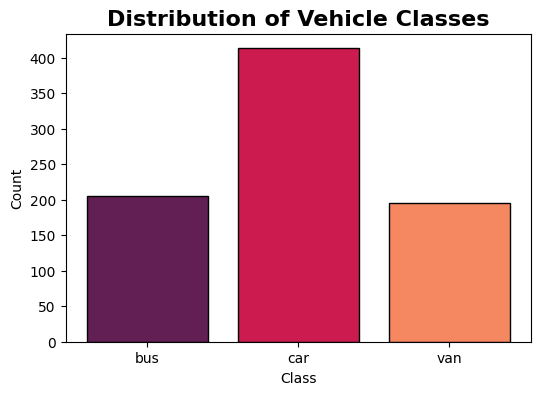

In [18]:
# Plot class distribution using a bar plot
counts = df['class'].value_counts().sort_index()
palette = sns.color_palette("rocket", len(counts))

# Set plot size
plt.figure(figsize=(6,4))
plt.bar(counts.index, counts.values, color=palette, edgecolor='black', linewidth=1)

# Add title and axis labels
plt.title("Distribution of Vehicle Classes", fontsize=16, fontweight='bold')
plt.xlabel("Class", fontsize=10)
plt.ylabel("Count", fontsize=10)

# Show plot
plt.show()

The countplot confirms that the dataset is only mildly imbalanced, with approximately half of the observations labeled as `car` and the remaining split fairly evenly between `bus` and `van`. While this imbalance is not severe, it does mean that the model could develop a slight bias toward predicting `car` more frequently. To ensure fair performance across all classes, I will need to be mindful of this distribution during training and evaluation, using per‑class metrics and, if necessary, techniques such as class weighting to prevent the model from favoring the majority class.

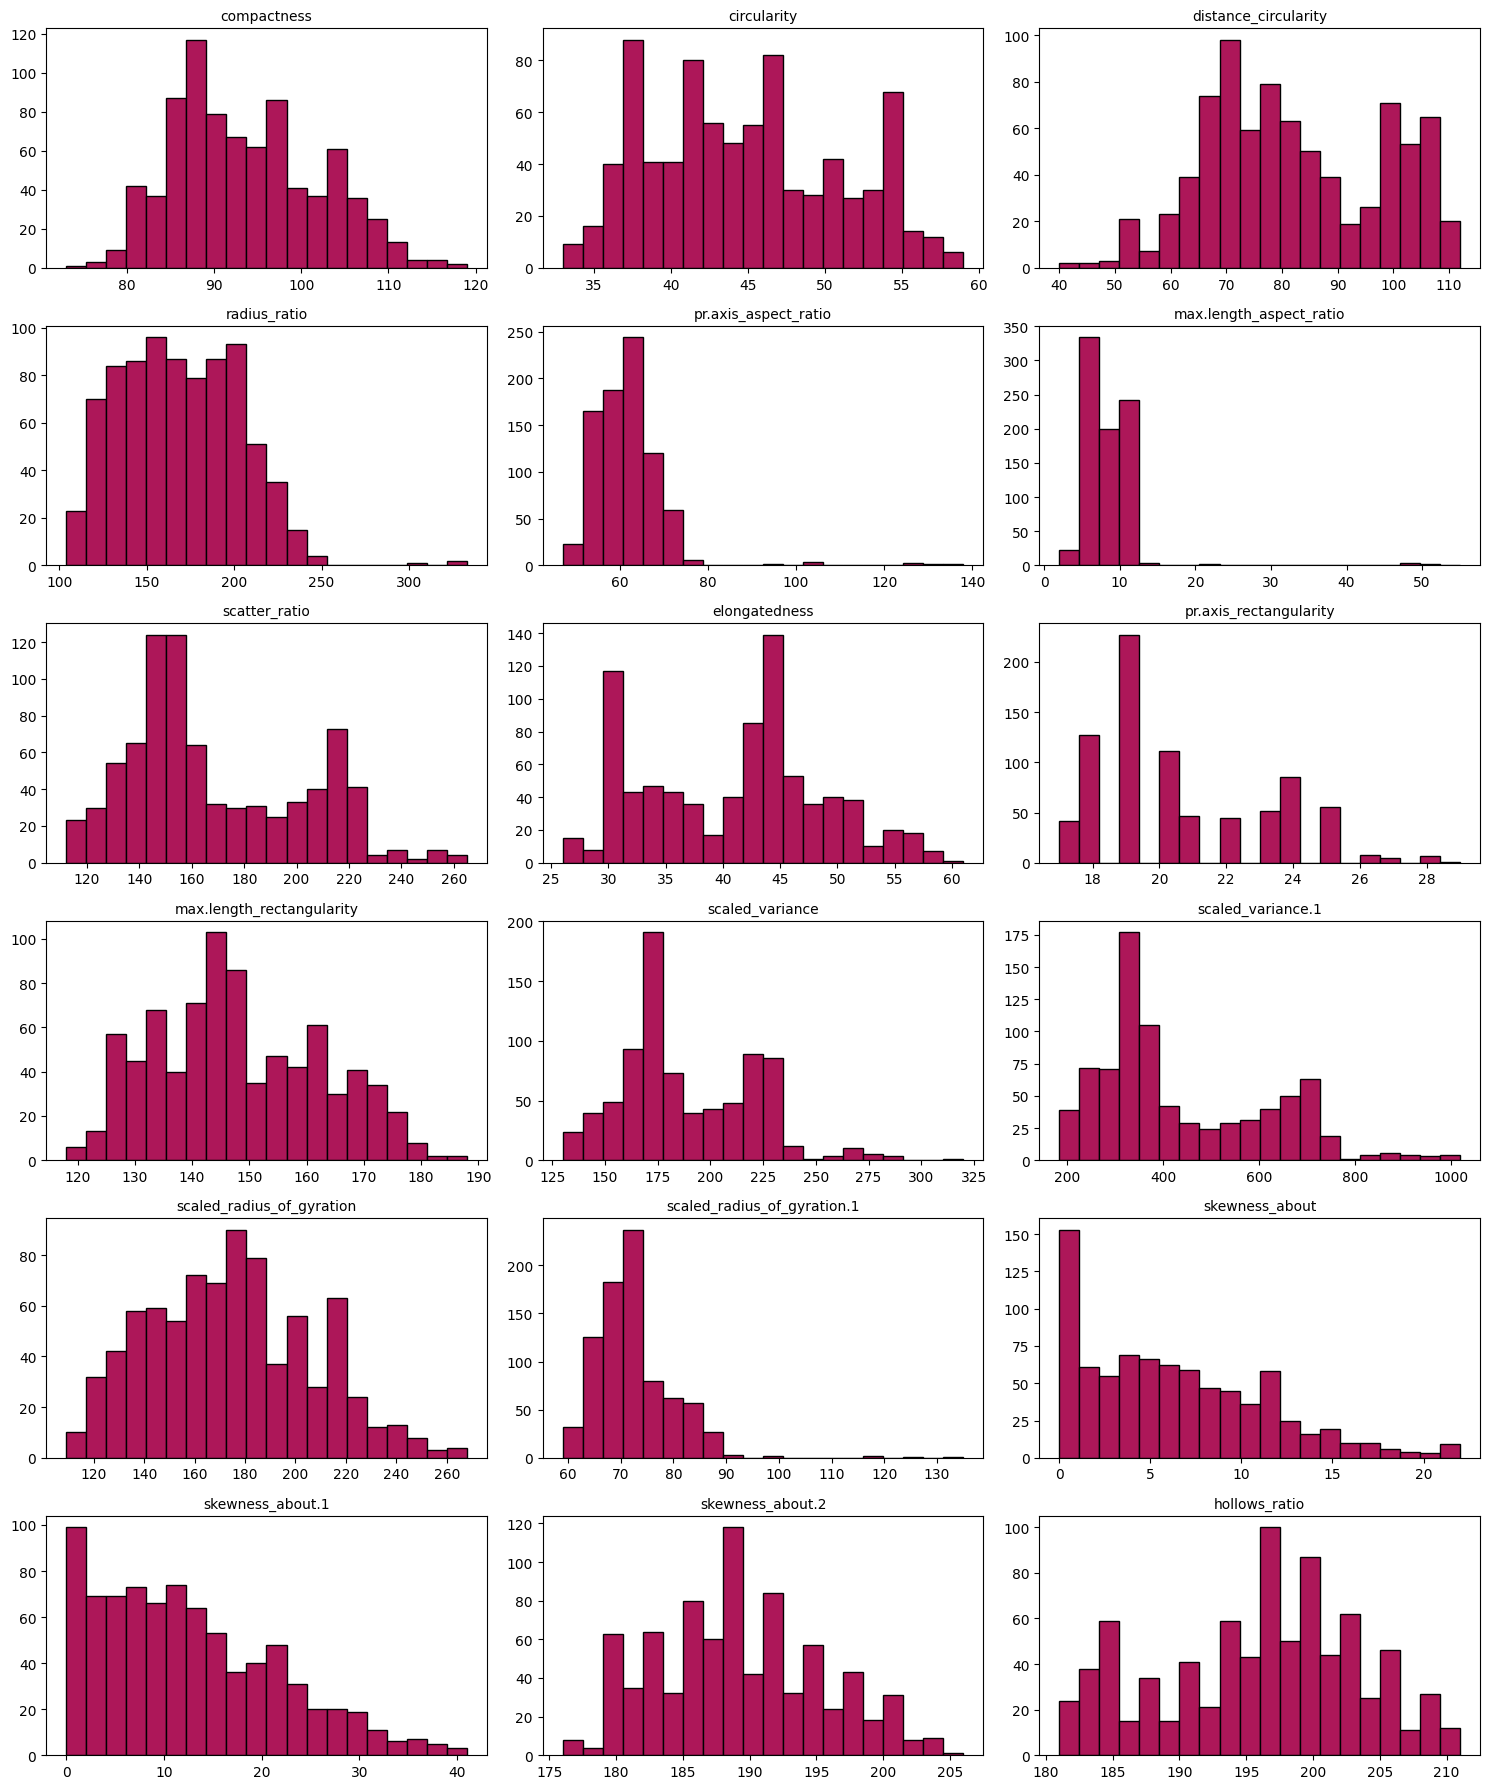

In [19]:
# Select only numeric columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Set up grid size based on number of features
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols*5, n_rows*3))

# Create histograms for all numerical columns
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col], bins=20, color=sns.color_palette("rocket")[2], edgecolor='black')
    plt.title(col, fontsize=10)
    plt.tight_layout()

# Show plot
plt.show()

The diagnostic table offered a useful first pass, flagging six variables as “possible right skew.” However, visual inspection of the histograms revealed that skewness is more widespread. In fact, most features display clear right skew, with only `compactness` and `circularity` appearing balanced and `distance_circularity` leaning left. These findings suggest that several variables may benefit from transformations prior to modeling to mitigate the influence of long tails and improve overall model performance.

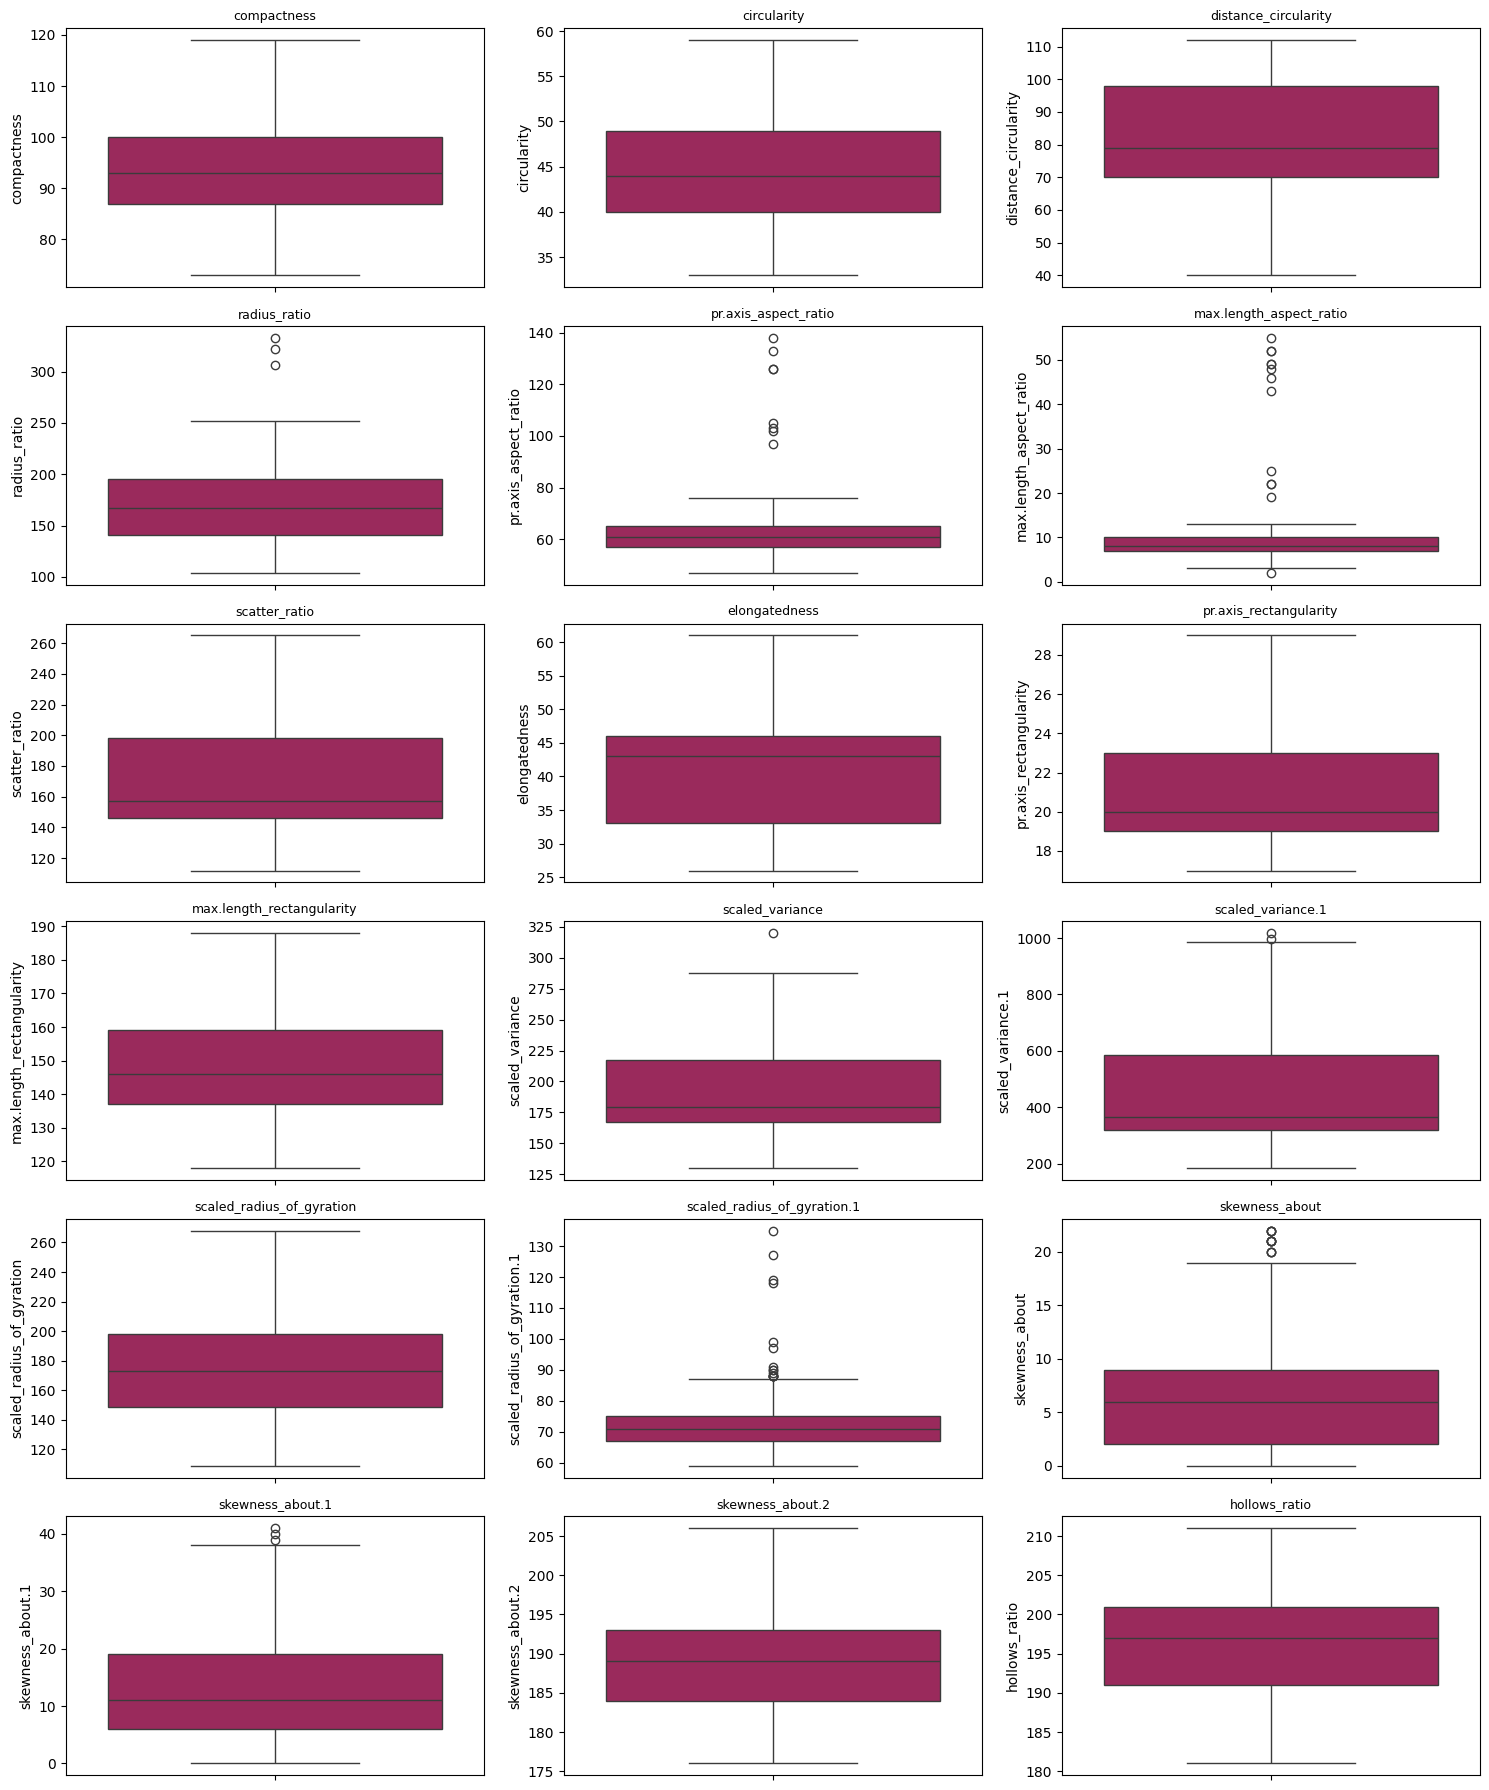

In [20]:
# Select only numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

# Set up grid size based on number of features
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols*5, n_rows*3))

# Create boxplots for all numerical columns
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[col], color=sns.color_palette("rocket")[2])
    plt.title(col, fontsize=9)
    plt.tight_layout()

# Show plot
plt.show()

The diagnostic table highlighted several variables with potential outlier issues, ranging from “some” to “strong.” Boxplots for each numeric feature confirmed these results, with `pr.axis_aspect_ratio`, `max.length_aspect_ratio`, and `scaled_radius_of_gyration.1` showing particularly extreme values. These features may require transformation, capping, or the use of robust modeling techniques to limit the disproportionate influence of outliers on model performance.

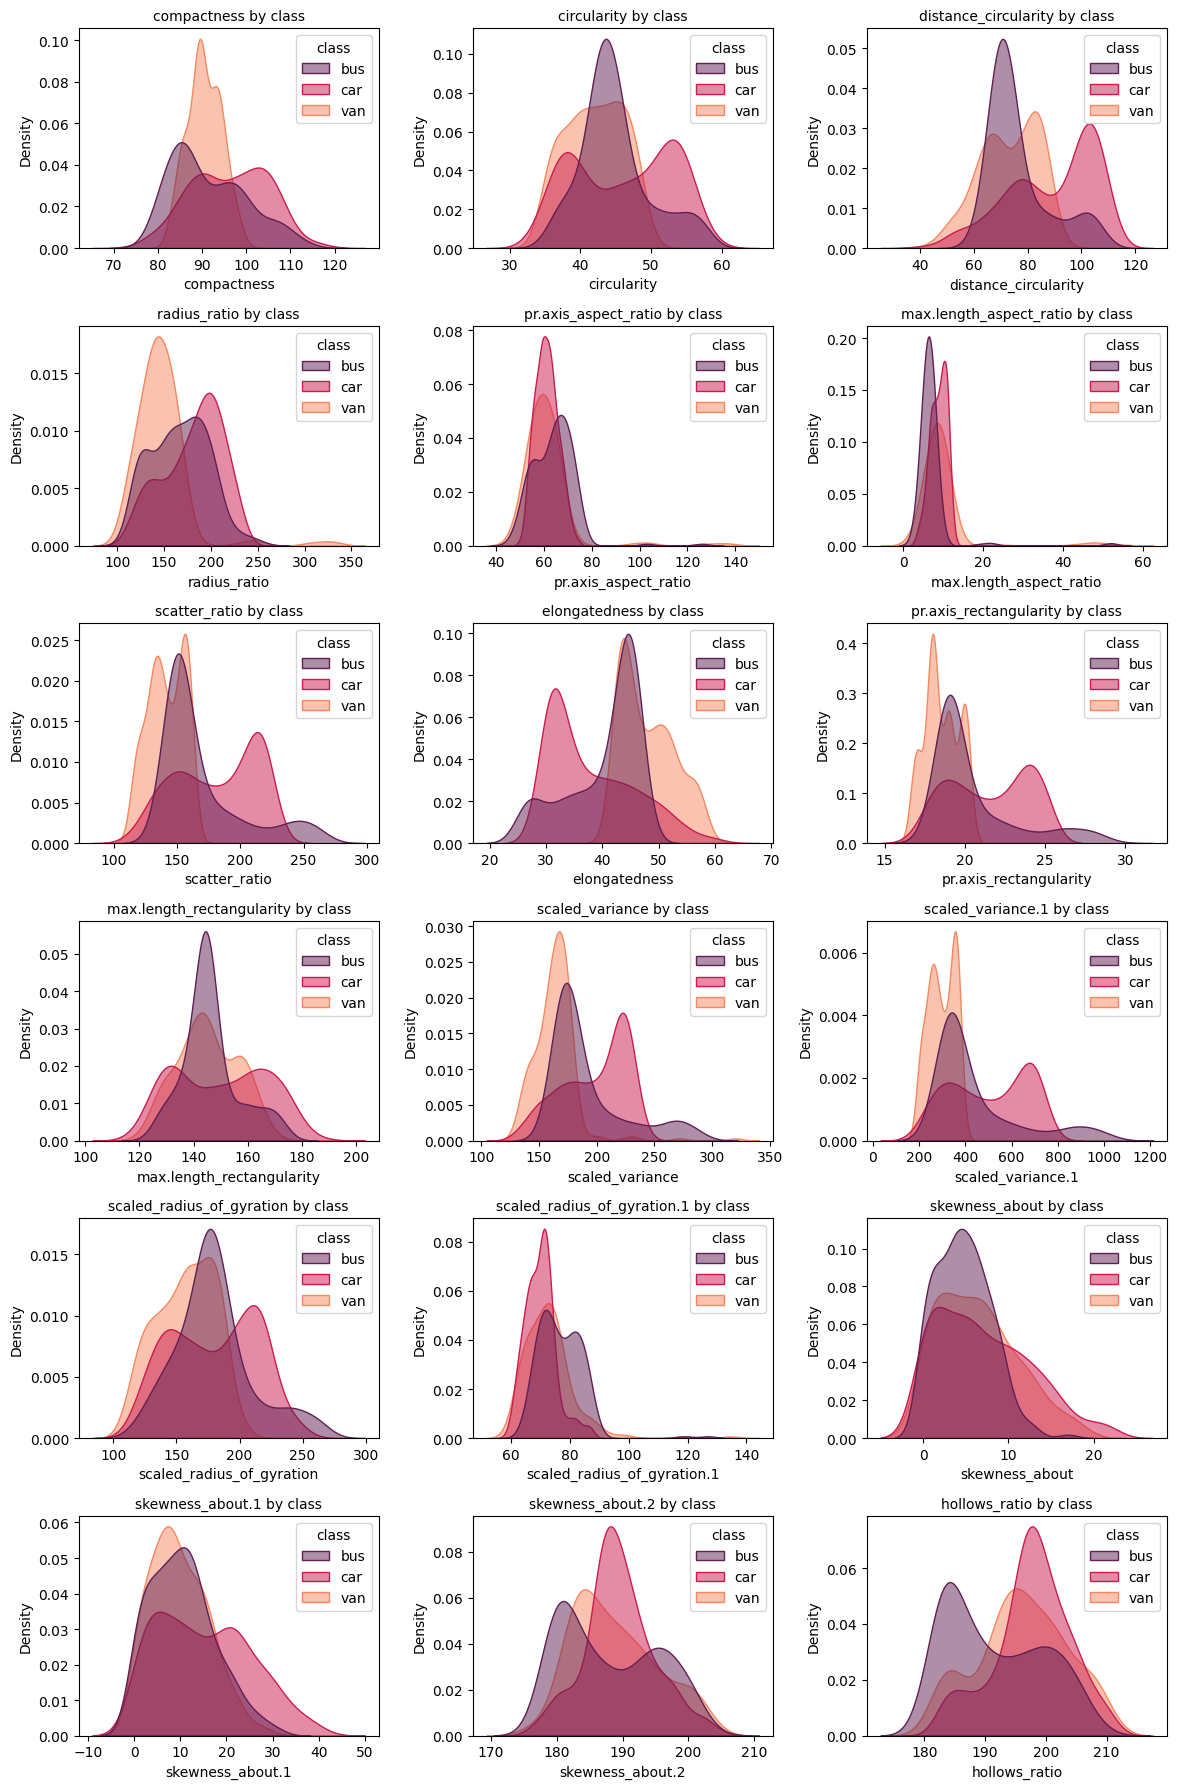

In [21]:
# Select only numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

# Set up grid size based on number of features
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows*3))
axes = axes.flatten()

# Create KDE distribution plots for all numerical columns by class
for i, col in enumerate(num_cols):
  sns.kdeplot(data=df, x=col, hue='class', palette='rocket', fill=True, common_norm=False, alpha=0.5, ax=axes[i])
  axes[i].set_title(f"{col} by class", fontsize=10)
  axes[i].set_xlabel(col)
  axes[i].set_ylabel("Density")

#Show plot
plt.tight_layout()
plt.show()

The KDE density plots highlight how each feature’s distribution differs across the three classes. Features that display multiple distinct peaks across the spread of the graph are especially informative, as they suggest class‑specific patterns in the data. Based on the visualizations (excluding those already earmarked as outliers), the following features showed clear multi‑peak behavior across classes: `distance_circularity`, `scatter_ratio`, `elongatedness`, `pr.axis_rectangularity`, `scaled_variance`, `scaled_variance.1`, `scaled_radius_of_gyration`, and `hollows_ratio`.

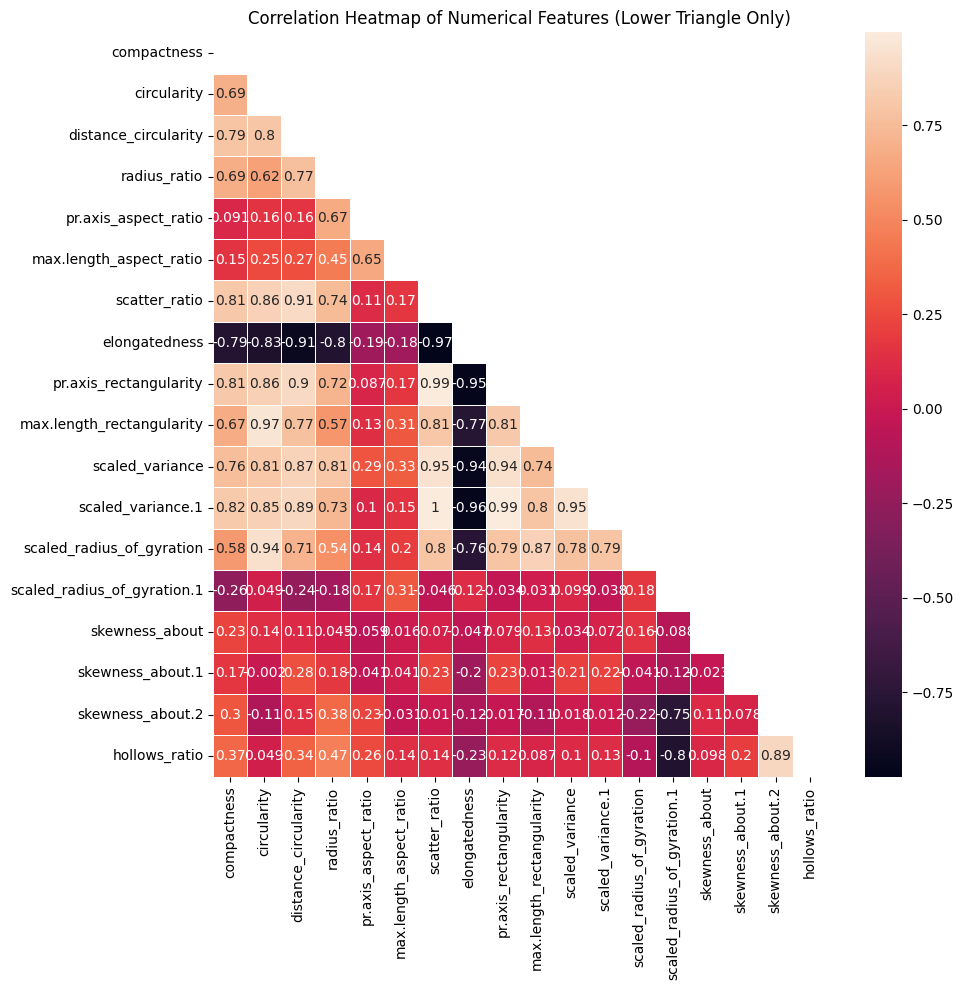

In [22]:
# Select only numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns
numeric_df = df[num_cols]

# Compute correlation matrix
corr = numeric_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up figure
plt.figure(figsize=(10, 10))

# Generate heatmap with mask
sns.heatmap(corr, mask=mask, annot=True, cmap="rocket", linewidths=0.5)

# Add title and show plot
plt.title("Correlation Heatmap of Numerical Features (Lower Triangle Only)")
plt.tight_layout()
plt.show()

The correlation heatmap revealed two main patterns. First, `elongatedness` has a strong negative correlation with most other features, effectively acting as their inverse signal. Second, a large group of features show strong positive correlations with one another, including `compactness`, `circularity`, `distance_circularity`, and `radius_ratio`, indicating redundancy within this cluster. By contrast, features such as `pr.axis_aspect_ratio`, `max.length_aspect_ratio`, `scaled_radius_of_gyration.1`, and the `skewness_about` measures are less correlated with the main cluster and may provide more unique information for the classification model.

### 3.4 - Summary of Findings

The exploratory analysis highlighted several considerations that will shape the modeling approach:

- **Class balance**

  The dataset is mildly imbalanced, with `car` making up about half the observations. This means accuracy alone is not a reliable metric. Per‑class metrics (precision, recall, F1) will be used for evaluating the model.

- **Skewness and outliers**

  Many features are skewed and contain outliers. To reduce the influence of long tails and extreme values, scaling and potentially robust transformations will be applied.

- **Feature usefulness**

  Some variables show clearer separation between classes and are likely to be more informative, while others are highly correlated and may be redundant. Dimensionality reduction or feature selection will help focus the model on the most distinctive signals.

## 4 - Supervised Learning Model

### 4.1 - Preprocessing

Since `class` is our target variable, it needs to be converted into a numerical format that machine learning algorithms can interpret. To achieve this, I apply ordinal encoding, which maps each class label to a unique integer.

In [23]:
# Define a mapping from categorical class to numeric codes
class_map = {"bus": 0, "car": 1, "van": 2}

# Apply mapping to create a new encoded column
df['class_encoded'] = df['class'].map(class_map)

# Confirm encoding by checking value counts
print(df['class'].value_counts(), "\n")
print(df['class_encoded'].value_counts())

class
car    413
bus    205
van    195
Name: count, dtype: int64 

class_encoded
1    413
0    205
2    195
Name: count, dtype: int64


In [24]:
# As encoding has been confirmed, drop the original class column
df.drop(columns=['class'], inplace=True)

# Quick check to confirm only the encoded target remains
df.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class_encoded
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,2
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,2
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,1
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,2
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,0


### 4.2 - Split Features (X) and Target (y)

In [25]:
# Define features (X) and target (y)
X = df.drop(columns=['class_encoded'])
y = df['class_encoded']

# Quick check to confirm `class_encoded' not included to prevent data leakage
print(sorted(X.columns))

['circularity', 'compactness', 'distance_circularity', 'elongatedness', 'hollows_ratio', 'max.length_aspect_ratio', 'max.length_rectangularity', 'pr.axis_aspect_ratio', 'pr.axis_rectangularity', 'radius_ratio', 'scaled_radius_of_gyration', 'scaled_radius_of_gyration.1', 'scaled_variance', 'scaled_variance.1', 'scatter_ratio', 'skewness_about', 'skewness_about.1', 'skewness_about.2']


### 4.3 - Split into Train/Test

In [26]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Quick check
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nClass distribution in train:\n", y_train.value_counts(normalize=True))
print("\nClass distribution in test:\n", y_test.value_counts(normalize=True))

Training set size: (650, 18)
Test set size: (163, 18)

Class distribution in train:
 class_encoded
1    0.507692
0    0.252308
2    0.240000
Name: proportion, dtype: float64

Class distribution in test:
 class_encoded
1    0.509202
0    0.251534
2    0.239264
Name: proportion, dtype: float64


The train/test split produced balanced subsets, with class proportions in the training and test sets closely matching the overall distribution. This ensures that evaluation will be fair and representative of the full dataset. With the target variable encoded and the data split, the next step is to scale the numeric features so that differences in magnitude and skewness do not distort model training.

### 4.4 - Feature Scaling

To ensure that all numeric features contribute comparably to the model, I apply **Robust Scaling**. Unlike standard z‑score scaling, which is sensitive to extreme values, RobustScaler uses the median and interquartile range, making it more resilient to the skewness and outliers observed in this dataset. This approach preserves the meaningful variation of rare but valid cases (such as unusually large vehicles) while reducing the disproportionate influence of long‑tailed distributions. Scaling is performed after the train/test split, with the scaler fit only on the training data, to prevent information from the test set leaking into the training process.

In [27]:
# Initialize RobustScaler
scaler = RobustScaler()

# Fit on training data only, then transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Quick statistical check to confirm scaling
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
compactness,650.0,0.055777,0.699630,-1.702128,-0.425532,0.0,0.574468,2.212766
circularity,650.0,0.090256,0.683282,-1.222222,-0.444444,0.0,0.555556,1.666667
distance_circularity,650.0,0.112663,0.596323,-1.423077,-0.346154,0.0,0.653846,1.269231
radius_ratio,650.0,0.015385,0.624138,-1.185185,-0.500000,0.0,0.500000,3.055556
pr.axis_aspect_ratio,650.0,0.085000,0.992526,-1.750000,-0.500000,0.0,0.500000,9.625000
max.length_aspect_ratio,650.0,0.192821,1.498073,-1.666667,-0.333333,0.0,0.666667,14.666667
scatter_ratio,650.0,0.228446,0.640582,-0.843137,-0.196078,0.0,0.803922,2.058824
elongatedness,650.0,-0.158817,0.591230,-1.307692,-0.769231,0.0,0.230769,1.230769
pr.axis_rectangularity,650.0,0.140000,0.636596,-0.750000,-0.250000,0.0,0.750000,2.000000
max.length_rectangularity,650.0,0.090629,0.662045,-1.272727,-0.409091,0.0,0.590909,1.909091


### 4.5 - Choose an Algorithm

To make an informed decision on which classification model to use, I compare the performance of several algorithms: Logistic Regression, Decision Tree, Random Forest, and Support Vector Machine. Evaluating these models side by side provides a clear view of their strengths and limitations, allowing me to select the most effective approach for this dataset.


Model: Logistic Regression


,Precision,Recall,F1
0,0.907,0.951,0.929
1,0.952,0.952,0.952
2,0.946,0.897,0.921


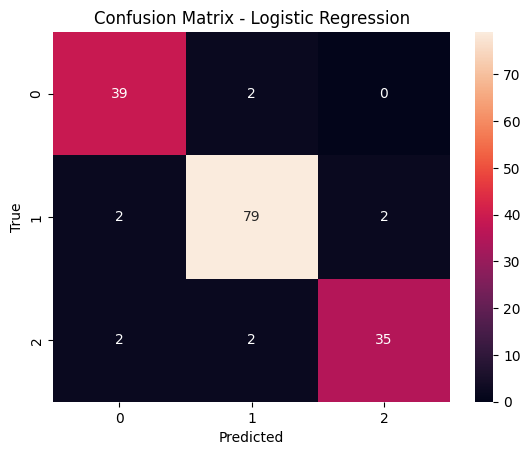


Model: Decision Tree


,Precision,Recall,F1
0,0.944,0.829,0.883
1,0.840,0.952,0.893
2,0.909,0.769,0.833


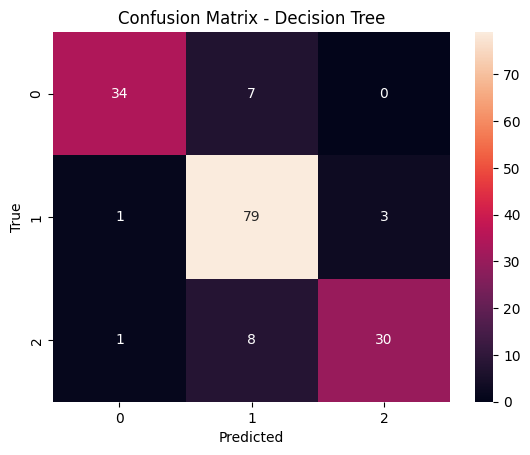


Model: Random Forest


,Precision,Recall,F1
0,1.000,0.976,0.988
1,0.975,0.928,0.951
2,0.864,0.974,0.916


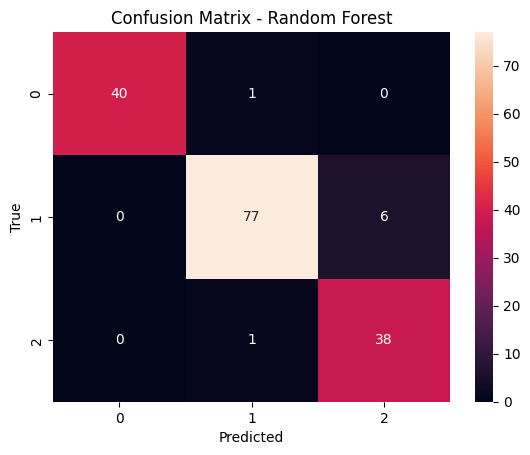


Model: SVM


,Precision,Recall,F1
0,1.000,1.000,1.000
1,0.940,0.952,0.946
2,0.895,0.872,0.883


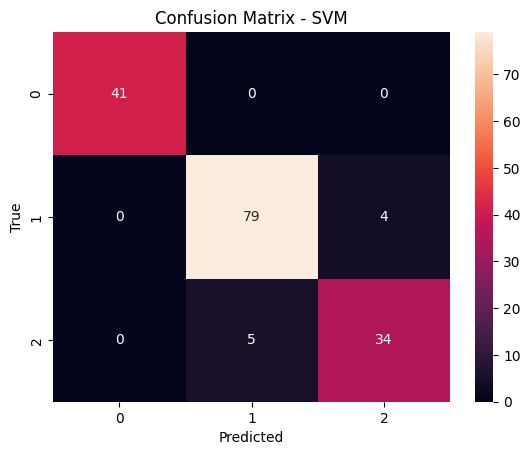

In [28]:
# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Define the metrics for evaluation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Build per-class metrics table
    metrics = {
        "Precision": precision_score(y_test, y_pred, average=None),
        "Recall": recall_score(y_test, y_pred, average=None),
        "F1": f1_score(y_test, y_pred, average=None)
    }
    metrics_df = pd.DataFrame(metrics)
    print(f"\nModel: {name}")
    display(metrics_df.round(3))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Run evaluation for each model
for name, model in models.items():
    evaluate_model(name, model, X_train_scaled, y_train, X_test_scaled, y_test)

Based on the evaluation results, I will proceed with Logistic Regression as it provides the most balanced performance across all classes. While Random Forest and SVM achieved very strong results in certain areas, both showed a tendency to confuse specific classes, leading to less consistent outcomes. Logistic Regression, on the other hand, delivered high precision, recall, and F1 scores across the board, with only minimal misclassifications. This consistency makes it the most reliable choice for the task, ensuring fair treatment of all categories without disproportionately favoring one over another.

In [29]:
# Create a logistic regression model
model = LogisticRegression(max_iter=1000, random_state=42)

### 4.6 - Fit the Model

In [30]:
# Fit the model
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

### 4.7 - Predict with Test Data

In [31]:
# Predict on training data to check fit
y_pred_train = model.predict(X_train_scaled)

# Predict on unseen test data
y_pred_test = model.predict(X_test_scaled)

### 4.8 - Evaluate Model

Training Data Evaluation:

              precision    recall  f1-score   support

           0      0.926     0.921     0.924       164
           1      0.966     0.955     0.960       330
           2      0.944     0.974     0.959       156

    accuracy                          0.951       650
   macro avg      0.946     0.950     0.948       650
weighted avg      0.951     0.951     0.951       650



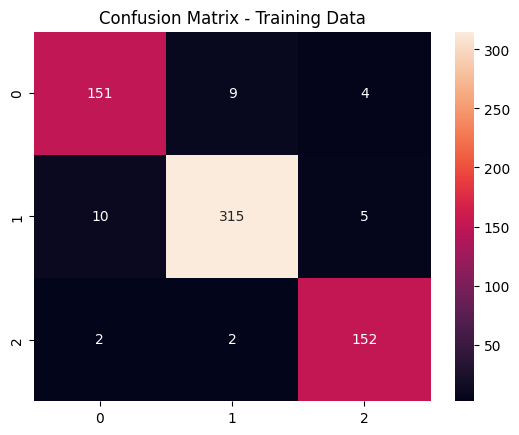

In [32]:
# Evaluate the prediction on the Training Data
print("Training Data Evaluation:\n")
print(classification_report(y_train, y_pred_train, digits=3))

# Plot a confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket')
plt.title("Confusion Matrix - Training Data")
plt.show()

Test Data Evaluation:

              precision    recall  f1-score   support

           0      0.907     0.951     0.929        41
           1      0.952     0.952     0.952        83
           2      0.946     0.897     0.921        39

    accuracy                          0.939       163
   macro avg      0.935     0.933     0.934       163
weighted avg      0.939     0.939     0.939       163



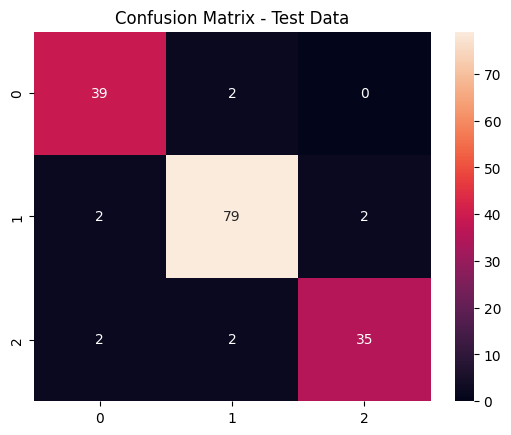

In [33]:
# Evaluate the prediction on unseen test data
print("Test Data Evaluation:\n")
print(classification_report(y_test, y_pred_test, digits=3))

# Plot a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket')
plt.title("Confusion Matrix - Test Data")
plt.show()

The Logistic Regression model demonstrates strong and consistent performance, with training accuracy at 95.1% and test accuracy at 93.9%. The close alignment between training and test results indicates that the model has fit the data well without significant overfitting. Precision, recall, and F1 scores remain high across all classes, confirming that the model generalizes effectively to unseen data and provides balanced predictions. The confusion matrices show that most errors occur between classes 1 and 2, but these misclassifications are relatively few and do not materially affect overall performance.

## 5 - Conclusion

This project successfully addressed Prospect Auto’s classification problem by applying a structured data science workflow, from exploratory analysis through supervised modeling and evaluation. After comparing multiple algorithms, Logistic Regression emerged as the most balanced and reliable model, achieving 95.1% accuracy on the training set and 93.9% accuracy on unseen test data. Performance metrics across all classes were consistently high, with only minor misclassifications observed between classes 1 and 2. The close alignment between training and test results confirms that the model generalizes well without significant overfitting.

Based on these findings, I recommend deploying the Logistic Regression model for Prospect Auto’s classification task, as it provides both strong predictive performance and interpretability, making it a dependable choice for practical use.

Having established that silhouette‑based features are sufficient for accurate vehicle classification, the next step is to explore whether unsupervised learning methods can uncover the same structure without labeled data. This follow‑up analysis is presented in the [Unsupervised Learning Project Notebook](../notebooks/02-unsupervised.ipynb).